<a href="https://colab.research.google.com/github/IronmanBD/LeNet-5-Implementation/blob/main/optimizer_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 20

train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle = True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


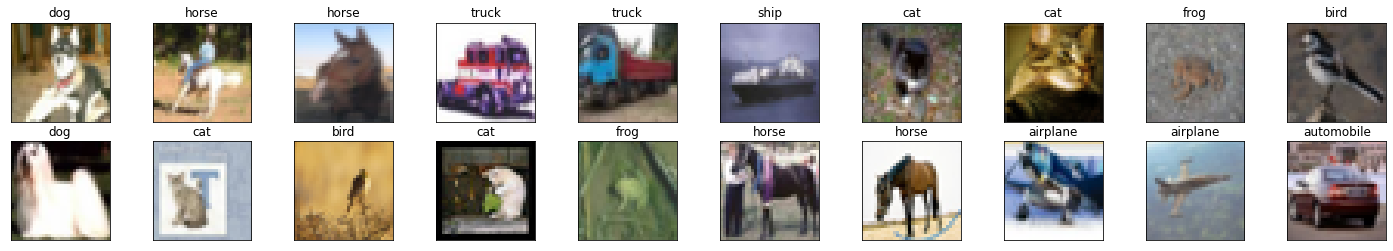

In [3]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [4]:
from torchvision import models
# Load the pretrained model from pytorch
model = models.resnet18(pretrained=True)
# print out the model structure
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [5]:
for param in model.parameters():
    param.requires_grad = False

In [6]:
model.fc = nn.Linear(512, len(classes))

In [7]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

if device == "cuda":
   model.cuda()
print(device)

cuda


In [40]:
optimizers = {
        'SGD': 'optim.SGD(model.parameters(), lr=0.01, momentum=0.9)',
        'Adam': 'optim.Adam(model.parameters())',
        #'Adadelta': 'optim.Adadelta(model.parameters())',
        #'Adagrad': 'optim.Adagrad(model.parameters())',
        'AdamW': 'optim.AdamW(model.parameters())',
        'Adamax': 'optim.Adamax(model.parameters())',
        #'ASGD': 'optim.ASGD(model.parameters())',
    }

In [41]:
epochs = 30

optim_keys = list(optimizers.keys())
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [42]:
import time
for i, optim_key in enumerate(optim_keys):
    print('-------------------------------------------------------')
    print('Optimizer:', optim_key)
    print('-------------------------------------------------------')
    print("{:<8} {:<25} {:<25} {:<25} {:<25} {:<25}".format('Epoch', 'Train Acc', 'Train Loss', 'Val Acc', 'Val Loss', 'Train Time'))
    
    model.to(device)

    optimizer = eval(optimizers[optim_key])
    criterion = nn.CrossEntropyLoss()
    
    model.train()
    
    optim_train_acc = []
    optim_test_acc = []
    optim_train_loss = []
    optim_test_loss = []

    for epoch in range(epochs):

        start = time.time()

        epoch_loss = []
        epoch_accuracy = []
        
        for step, batch in enumerate(trainloader):
            
            optimizer.zero_grad()
            
            batch = tuple(t.to(device) for t in batch)
            images, labels = batch
            
            out = model(images)
            
            loss = criterion(out, labels)
            
            confidence, predictions = out.max(dim=1)
            truth_values = predictions == labels
            acc = truth_values.sum().float().detach().cpu().numpy() / truth_values.shape[0]
            
            epoch_accuracy.append(acc)
            epoch_loss.append(loss.float().detach().cpu().numpy().mean())
            
            loss.backward()
            optimizer.step()
        
        optim_train_loss.append(np.mean(epoch_loss))
        optim_train_acc.append(np.mean(epoch_accuracy))
        
        test_epoch_loss = []
        test_epoch_accuracy = []
        
        end = time.time()
        
        model.eval()
        for step, batch in enumerate(testloader):
            
            batch = tuple(t.to(device) for t in batch)
            images, labels = batch
            
            out = model(images)
            
            loss = criterion(out, labels)
            
            confidence, predictions = out.max(dim=1)
            truth_values = predictions == labels
            acc = truth_values.sum().float().detach().cpu().numpy() / truth_values.shape[0]
            
            test_epoch_accuracy.append(acc)
            test_epoch_loss.append(loss.float().detach().cpu().numpy().mean())
        
        optim_test_loss.append(np.mean(test_epoch_loss))
        optim_test_acc.append(np.mean(test_epoch_accuracy))
        
        print("{:<8} {:<25} {:<25} {:<25} {:<25} {:<25}".format(epoch+1, 
                                                                np.mean(epoch_accuracy), 
                                                                np.mean(epoch_loss), 
                                                                np.mean(test_epoch_accuracy), 
                                                                np.mean(test_epoch_loss), 
                                                                end-start))
    
    train_losses.append(optim_train_loss)
    test_losses.append(optim_test_loss)
    train_accuracies.append(optim_train_acc)
    test_accuracies.append(optim_train_acc)

-------------------------------------------------------
Optimizer: SGD
-------------------------------------------------------
Epoch    Train Acc                 Train Loss                Val Acc                   Val Loss                  Train Time               
1        0.31446                   3.7438621520996094        0.335                     3.4741463661193848        23.616348028182983       
2        0.34421999999999997       4.5571794509887695        0.328                     4.988137722015381         21.574002504348755       
3        0.35006                   4.6935133934021           0.3613                    4.407029151916504         21.62445855140686        
4        0.35214                   4.683248996734619         0.35669999999999996       4.367284774780273         21.548205375671387       
5        0.35212                   4.60212516784668          0.337                     4.858097553253174         21.545947074890137       
6        0.3513                    4.62

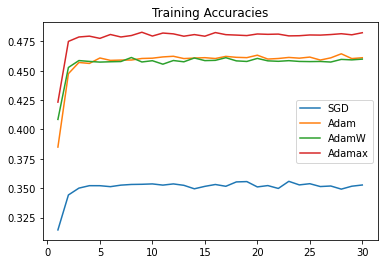

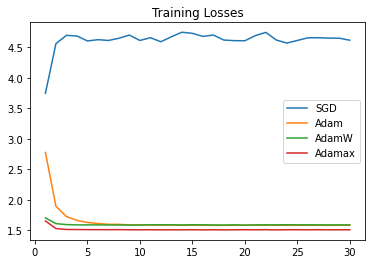

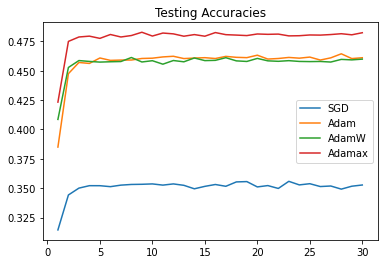

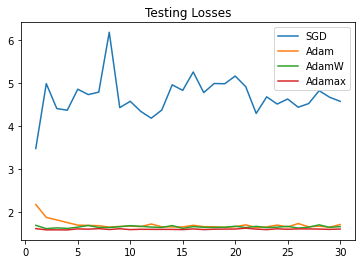

In [43]:
train_accuracies = dict(zip(optim_keys, train_accuracies))
test_accuracies = dict(zip(optim_keys, test_accuracies))
train_losses = dict(zip(optim_keys, train_losses))
test_losses = dict(zip(optim_keys, test_losses))

x = np.arange(epochs) + 1

for optim_key in optim_keys:
    plt.plot(x, train_accuracies[optim_key], label=optim_key)

plt.title('Training Accuracies')
plt.legend()
plt.show()


for optim_key in optim_keys:
    plt.plot(x, train_losses[optim_key], label=optim_key)

plt.title('Training Losses')
plt.legend()
plt.show()


for optim_key in optim_keys:
    plt.plot(x, test_accuracies[optim_key], label=optim_key)

plt.title('Testing Accuracies')
plt.legend()
plt.show()


for optim_key in optim_keys:
    plt.plot(x, test_losses[optim_key], label=optim_key)

plt.title('Testing Losses')
plt.legend()
plt.show()